In [1]:
.libPaths('/scratch/saberi/R_4.1.2')
NUM_THREADS = 2

In [2]:
library(data.table)
library(stringr)
library(parallel)
library(magrittr)
library(ggplot2)

In [3]:
setDTthreads(NUM_THREADS)

In [4]:
setwd('/scratch/saberi/isoseq/RTOpt')

s = c(rep(c('L', 'M'), each = 4) , rep('N', 2))
v = rep(c(1, 2), each = 2)
r = c(1, 2)
sample_names = str_c(s, '.v', v, '.r', r) %>% suppressWarnings

In [5]:
sample_names

[1] "L.v1.r1" "L.v1.r2" "L.v2.r1" "L.v2.r2" "M.v1.r1" "M.v1.r2" "M.v2.r1"
 [8] "M.v2.r2" "N.v1.r1" "N.v1.r2"

In [6]:
.get_fl_read_len = function(sn) {

    read_len_list_file = str_glue('samples/{sn}/{sn}.fl.read-len.list') 
    read_len = fread(read_len_list_file, header = F, col.names = c('read_id', 'len'))
    read_len[, sample := sn]
    read_len    
}

.get_flnc_read_len = function(sn) {

    read_len_list_file = str_glue('samples/{sn}/{sn}.flnc.read-len.list') 
    read_len = fread(read_len_list_file, header = F, col.names = c('read_id', 'len'))
    read_len[, sample := sn]
    read_len    
}

.get_clustered_read_len = function(sn) {

    read_len_list_file = str_glue('samples/{sn}/{sn}.clustered.hq.read-len.list') 
    read_len = fread(read_len_list_file, header = F, col.names = c('cluster_id', 'len'))
    read_len[, sample := sn]
    
    cluster_info_file = str_glue('samples/{sn}/{sn}.clustered.cluster_report.csv', select = 2)
    cluster_info = fread(cluster_info_file)
    cluster_info = cluster_info[, .N, cluster_id]

    read_len = merge(read_len, cluster_info, by = 'cluster_id')
    
    read_len = merge(read_len,
                    read_len[, .(index = seq(N)), cluster_id],
                    by = 'cluster_id')

    read_len
}

In [7]:
fl_read_len = lapply(sample_names, .get_fl_read_len)
flnc_read_len = lapply(sample_names, .get_flnc_read_len)
clustered_read_len = lapply(sample_names, .get_clustered_read_len)

In [8]:
fl_all = do.call(rbind, fl_read_len)
flnc_all = do.call(rbind, flnc_read_len)
clustered_all = do.call(rbind, clustered_read_len)

In [9]:
setwd('/scratch/saberi/isoseq')

sample_names = str_c(
    rep(LETTERS[1:7], each = 2),
    seq(2))

In [10]:
sample_names

[1] "A1" "A2" "B1" "B2" "C1" "C2" "D1" "D2" "E1" "E2" "F1" "F2" "G1" "G2"

In [11]:
fl_read_len = lapply(sample_names, .get_fl_read_len)
flnc_read_len = lapply(sample_names, .get_flnc_read_len)
clustered_read_len = lapply(sample_names, .get_clustered_read_len)

In [12]:
fl_all = do.call(rbind, fl_read_len) %>% rbind(fl_all)
flnc_all = do.call(rbind, flnc_read_len) %>% rbind(flnc_all)
clustered_all = do.call(rbind, clustered_read_len) %>% rbind(clustered_all)

In [13]:
.plot_read_len = function(read_len, read_type) {
    ggplot(read_len) +
        aes(x = sample, y = len) +
        geom_violin(width = 1, position=position_dodge(2), alpha = 0.25) +
        geom_boxplot(width = 0.25, alpha = 0.25) +
        theme_minimal() +
        theme(text=element_text(size=15)) + 
        labs(title = str_glue('PacBio IsoSeq Reads ({read_type}) Length per Sample')) +
        xlab('Sample') +
        scale_y_continuous(name = 'Reads Length', limits = c(0, 15e3), breaks = seq(0, 15e3, 1e3))
}

Warning message:
“Removed 11 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”


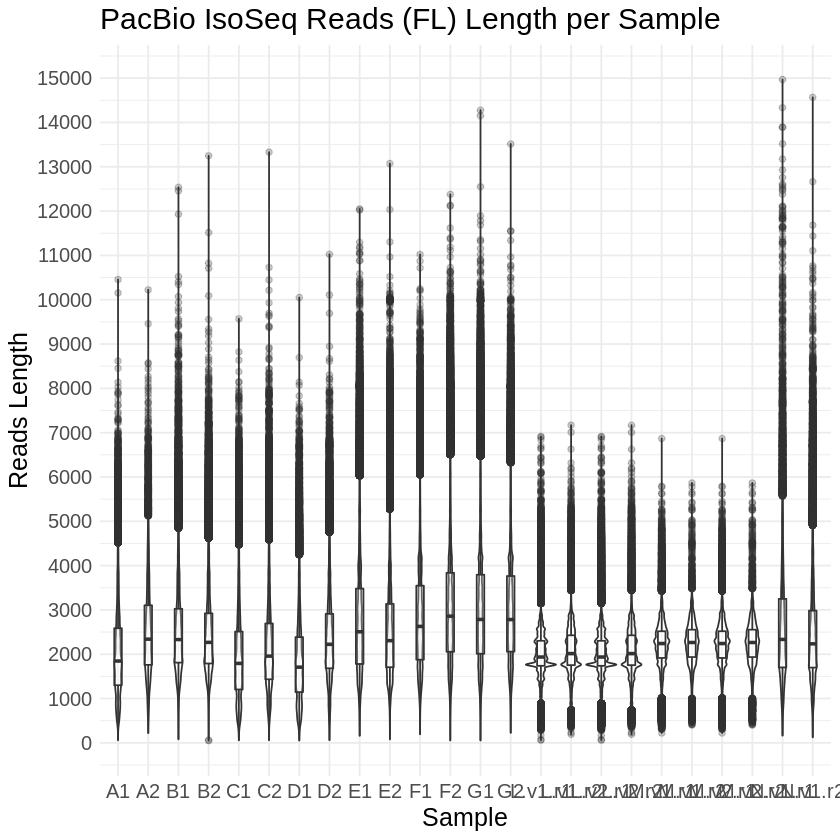

In [19]:
.plot_read_len(fl_all, 'FL')

In [14]:
fl_all[, type := 'FL']
flnc_all[, type := 'FLNC']
clustered_all[, type := 'HQ_Clustered']

In [16]:
colnames(fl_all)

[1] "read_id" "len"     "sample"  "type"

In [17]:
read_len_all = Reduce(rbind,
    list(fl_all[, .(sample, len, type)],
        flnc_all[, .(sample, len, type)],
        clustered_all[, .(sample, len, type)]))

In [39]:
read_len_plot = ggplot(read_len_all) +
    aes(x = sample, y = len, fill = type) +
    geom_boxplot(alpha = 0.25, outlier.shape = NA) +
    theme_minimal() +
    theme(text=element_text(size=15),
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(title = 'PacBio IsoSeq Reads Length per Sample') +
    xlab('Sample') +
    scale_y_continuous(name = 'Reads Length', limits = c(0, 7e3), breaks = seq(0, 7e3, 0.5e3))

In [40]:
ggsave(read_len_plot, device = 'pdf', file = 'plots/read_len_all_without_outliers.pdf', width = 15, height = 5)

Warning message:
“Removed 76325 rows containing non-finite values (stat_boxplot).”
